# Practice Session 09: Forecasting

In this session we will do some time series forecasting on a weather-related time series, which contains temperature, precipitation, and wind speed data for the Barcelona airport. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Guillem Escriba Molto</font>

E-mail: <font color="blue">guillem.escriba01@estudiant.upf.edu</font>

Date: <font color="blue">01/12/2022</font>

In [343]:
import io
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# 1. Dataset

In [344]:
# LEAVE AS-IS

INPUT_FILE = "aemet-barcelona-airport-2016-2022.json"
weather = pd.read_json(INPUT_FILE)

weather.head(5)

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",11:50,99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",11:50,13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",08:10,20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",10:30,25.0,"3,3","6,7",23:20,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",14:00,35.0,"3,1","6,4",02:00,NaN,NaN,NaN,NaN,NaN


In [345]:
# LEAVE AS-IS

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "time_temp_min",
  "horatmax" : "time_temp_max",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "time_windspeed_gusts",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "time_pressure_max",
  "presMin" : "pressure_min",
  "horaPresMin" : "time_pressure_min"
}

In [346]:
weather = weather.rename(columns=COLUMN_NAMES)
display(weather.head(3))

,date,station_num,station_name,station_province,station_altitude,temp_avg,rainfall,temp_min,time_temp_min,temp_max,time_temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,time_windspeed_gusts,sun,pressure_max,time_pressure_max,pressure_min,time_pressure_min
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",11:50,99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",11:50,13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",08:10,20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN


In [347]:
weather = weather.drop(['station_num', 'station_name', 'station_province', 'station_altitude', 'time_temp_min', 'time_temp_max', 'time_windspeed_gusts', 'time_pressure_max', 'time_pressure_min' ],axis=1)
display(weather.head(3))

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",NaN,NaN,NaN


In [348]:
def str_commas_to_float(x):
    if isinstance(x,float): # check if is already a float 
        return x
    elif isinstance(x,int): # '' '' an integer
        return float(x) 
    elif x == "Ip": 
        return 0.0
    elif ',' in x:
        return float(x.replace(',','.')) # replaces commas by floating points
    try:
        return float(x) # if is a single string number such as '2' it transforms to 2.0 float
    except:
        return np.nan # otherwise is transformed to NaN
    
    
        
    

In [349]:
assert np.isnan(str_commas_to_float("Varias")) == True
assert np.isnan(str_commas_to_float("06:30")) == True
assert str_commas_to_float("0,0") == 0.0
assert str_commas_to_float("Ip") == 0.0
assert str_commas_to_float("12,9") == 12.9
assert str_commas_to_float("13") == 13.0

In [350]:
weather['temp_min']        = weather['temp_min'].apply(str_commas_to_float)
weather['temp_max']        = weather['temp_max'].apply(str_commas_to_float)
weather['temp_avg']        = weather['temp_avg'].apply(str_commas_to_float)
weather['rainfall']        = weather['rainfall'].apply(str_commas_to_float)
weather['windspeed_dir']   = weather['windspeed_dir'].apply(str_commas_to_float)
weather['windspeed_avg']   = weather['windspeed_avg'].apply(str_commas_to_float)
weather['windspeed_gusts'] = weather['windspeed_gusts'].apply(str_commas_to_float)
weather['sun']             = weather['sun'].apply(str_commas_to_float)
weather['pressure_min']    = weather['pressure_min'].apply(str_commas_to_float)
weather['pressure_max']    = weather['pressure_max'].apply(str_commas_to_float)

In [351]:
# LEAVE AS-IS

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
weather.head(3)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN


In [352]:
# LEAVE AS-IS

# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

In [353]:
# LEAVE AS-IS

# Plot function
def plot(df, column, xlabel='Date', ylabel=''):
    
    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[column],
                  fmt='.-', color='black')

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def plot_min_avg_max(df, min_column='temp_min', avg_column='temp_avg', max_column='temp_max', xlabel='Date', ylabel='Daily temperature [C]'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[avg_column],
                  fmt='.-', color='black', label='Average')
    plt.fill_between(df.index, df[min_column], df[max_column],
                     color='lightgray')
    plt.legend()

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

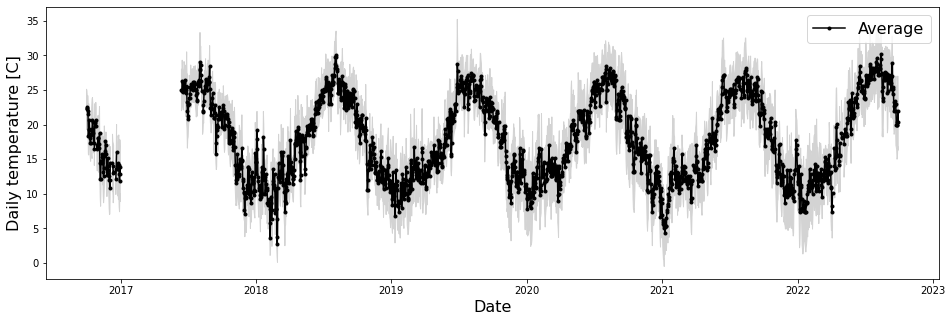

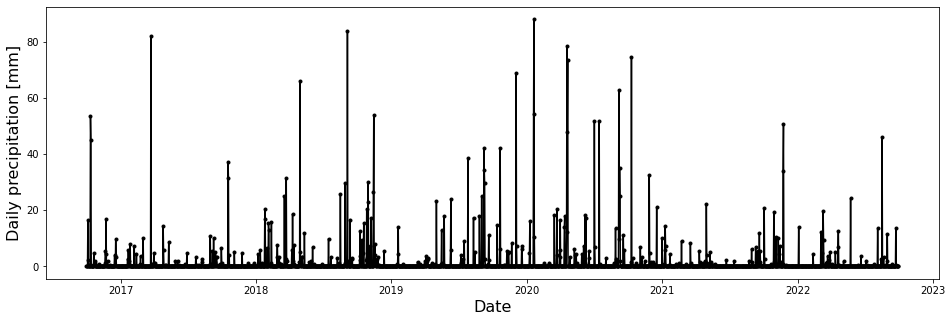

In [354]:
# LEAVE AS-IS

# Retrieve the last 6 years
weather_sample = weather.tail(6*365)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Daily precipitation [mm]")

<font size="+1">While in the precipitations graphic is not possible to identify any sesionality in the temperatures we can see the seasons corresponding to the year seasons, low temperatures in winter and high in summer with an increasement in spring and decreasement in autumm.</font>

## 1.1 Smooth the series using moving averages

In [355]:
def moving_average(df, window_size):

    smoothed = pd.DataFrame(columns=df.columns)
    
    for i in range(len(df)):
        if i<window_size: # computing the avg for the first rows 
            smoothed = smoothed.append(df.iloc[0:i+1].mean(),ignore_index=True) # mean of i-1 first rows 
        else:
            smoothed = smoothed.append(df.iloc[i-(window_size-1):i+1].mean(),ignore_index=True) # moving avg of 7 rows 

    smoothed.set_index(df.index, inplace=True)

    return smoothed

In [356]:
# LEAVE AS-IS

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.100000,0.000000,21.900000,26.300000,99.000000,3.100000,5.800000,NaN,NaN,NaN
2016-07-02,24.350000,0.000000,22.100000,26.650000,56.000000,3.350000,6.650000,NaN,NaN,NaN
2016-07-03,24.033333,0.000000,22.033333,26.066667,44.000000,3.633333,7.400000,NaN,NaN,NaN
2016-07-04,23.975000,0.000000,21.975000,26.025000,39.250000,3.550000,7.225000,NaN,NaN,NaN
2016-07-05,24.240000,0.000000,22.220000,26.300000,38.400000,3.460000,7.060000,NaN,NaN,NaN
2016-07-06,24.500000,0.000000,22.366667,26.666667,35.333333,3.716667,7.833333,NaN,NaN,NaN
2016-07-07,24.628571,0.000000,22.557143,26.728571,44.428571,3.742857,8.185714,NaN,NaN,NaN
2016-07-08,24.928571,0.014286,22.857143,27.028571,33.571429,3.657143,8.871429,NaN,NaN,NaN
2016-07-09,25.214286,0.014286,23.214286,27.242857,34.285714,3.585714,8.757143,NaN,NaN,NaN


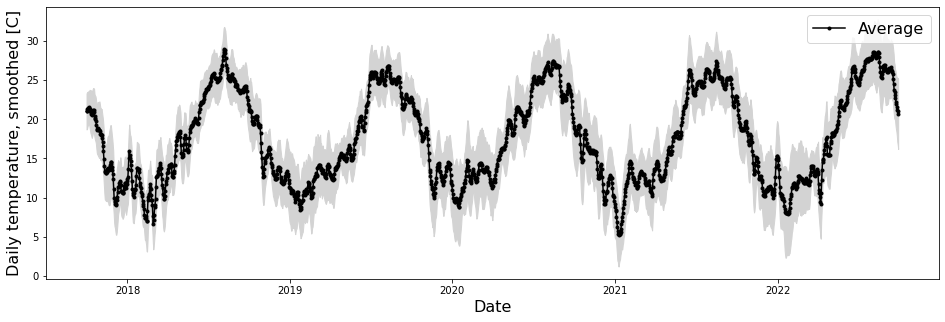

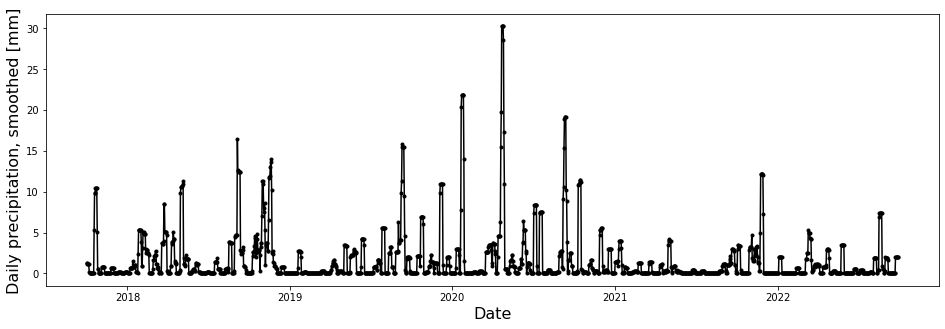

In [357]:
# LEAVE AS-IS

# Sample last 5 years
weather_smoothed_sample = weather_smoothed.tail(5*365)

# Plot smoothed temperature
plot_min_avg_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]')

# Plot smoothed precipitation
plot(weather_smoothed_sample, "rainfall", ylabel="Daily precipitation, smoothed [mm]")

<font size="+1">The main dificulty of the moving average is in the values of the boundaries (in this case the start) where we have less values than window size so it is not possible to compute a mean.</font>

In [358]:
test = weather.copy()
passes = 20
window_size = 7
for i in range(passes):
    test = moving_average(test, window_size)


,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.100000,0.000000e+00,21.900000,26.300000,99.000000,3.100000,5.800000,NaN,NaN,NaN
2016-07-02,24.100000,0.000000e+00,21.900000,26.300001,98.999918,3.100000,5.800002,NaN,NaN,NaN
2016-07-03,24.100001,0.000000e+00,21.900001,26.300001,98.999836,3.100001,5.800003,NaN,NaN,NaN
2016-07-04,24.100001,0.000000e+00,21.900001,26.300002,98.999754,3.100001,5.800005,NaN,NaN,NaN
2016-07-05,24.100002,0.000000e+00,21.900002,26.300003,98.999672,3.100002,5.800006,NaN,NaN,NaN
2016-07-06,24.100002,0.000000e+00,21.900002,26.300003,98.999590,3.100002,5.800008,NaN,NaN,NaN
2016-07-07,24.100003,0.000000e+00,21.900002,26.300004,98.999508,3.100003,5.800010,NaN,NaN,NaN
2016-07-08,24.100004,1.253254e-18,21.900003,26.300006,98.999312,3.100004,5.800014,NaN,NaN,NaN
2016-07-09,24.100005,2.506509e-17,21.900004,26.300008,98.999070,3.100005,5.800018,NaN,NaN,NaN


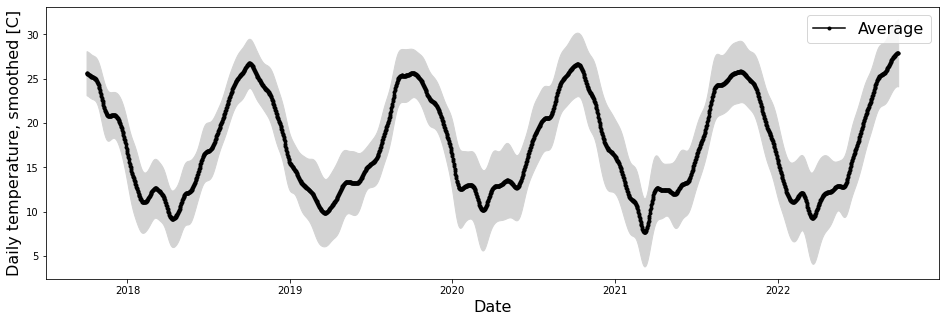

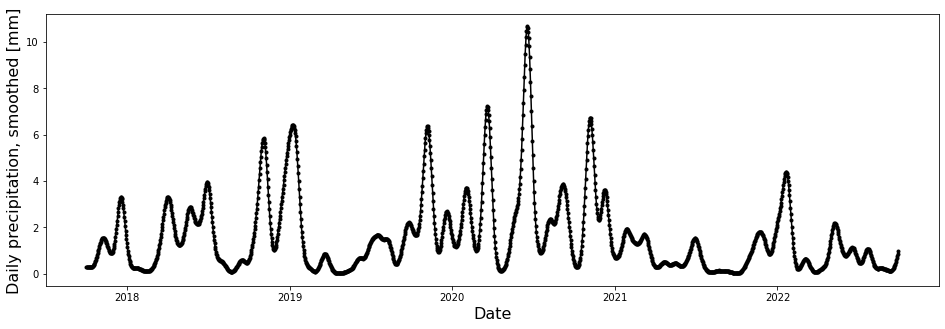

In [359]:
display(test.head(10))

# Sample last 5 years
test_smoothed_sample = test.tail(5*365)

# Plot smoothed temperature
plot_min_avg_max(test_smoothed_sample, ylabel='Daily temperature, smoothed [C]')

# Plot smoothed precipitation
plot(test_smoothed_sample, "rainfall", ylabel="Daily precipitation, smoothed [mm]")

<font size="+1">Because if we compute a mean of a moving average several times, the values tends to smooth converging at tge infinite to the global average.</font>

## 1.2. Smooth the series by binning per floating weeks

In [360]:
def list_of_floating_week_starts(first, last):
    weeks = []

    while(first<last):
        weeks.append(first)
        first = first + datetime.timedelta(weeks=1) # 7-day increment
    weeks.append(first) # last week

    return(weeks)

In [361]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
weeks = list_of_floating_week_starts(first_day, last_day)

print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" % (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 327 week starts
First week starts 2016-07-01, last week starts 2022-09-30


In [362]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start
date,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,2016-07-01
2016-07-06,25.8,0.0,23.1,28.5,20.0,5.0,11.7,NaN,NaN,NaN,2016-07-01
2016-07-07,25.4,0.0,23.7,27.1,99.0,3.9,10.3,NaN,NaN,NaN,2016-07-01
2016-07-08,26.2,0.1,24.0,28.4,23.0,2.5,10.6,NaN,NaN,NaN,2016-07-08
2016-07-09,26.6,0.0,24.8,28.5,18.0,3.1,6.7,NaN,NaN,NaN,2016-07-08


In [363]:
dictionary = {'temp_min': np.mean, 'temp_avg':np.mean, 'temp_max': np.mean, 'rainfall': np.sum}
weather_per_floating_week = weather_with_week_start.groupby('week_start').agg(dictionary, axis=0)
display(weather_per_floating_week.head(10))

,temp_min,temp_avg,temp_max,rainfall
week_start,,,,
2016-07-01,22.557143,24.628571,26.728571,0.0
2016-07-08,23.128571,25.314286,27.500000,0.4
2016-07-15,21.485714,24.171429,26.871429,0.6
2016-07-22,22.542857,25.428571,28.328571,5.8
2016-07-29,24.028571,25.957143,27.871429,0.6
2016-08-05,22.240000,24.240000,26.280000,0.1
2016-08-12,22.300000,24.800000,27.328571,0.0
2016-08-19,22.460000,25.260000,28.080000,0.0
2016-08-26,22.785714,25.200000,27.585714,8.0


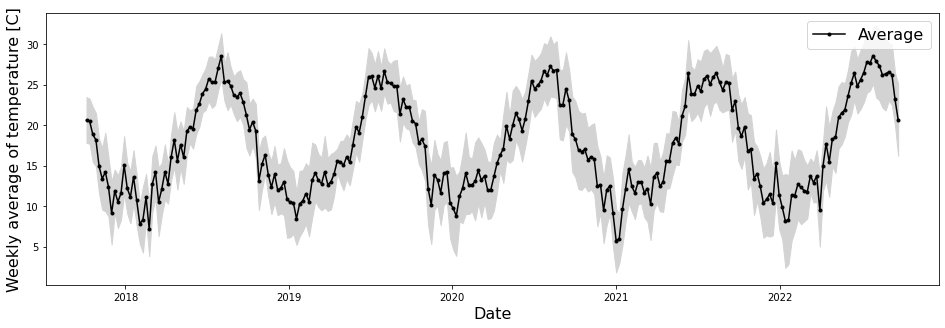

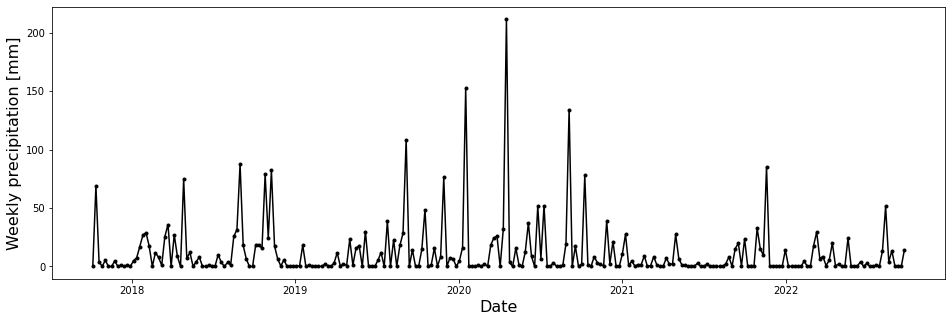

In [364]:
# LEAVE AS-IS

# Retrieve the past 5 years
weather_sample = weather_per_floating_week.tail(5*52)

# Plot temperature
plot_min_avg_max(weather_sample, ylabel="Weekly average of temperature [C]")

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Weekly precipitation [mm]")

<font size="+1">In this case instead of smoothing by computing a moving average of all the points we have computed the average of some grouped points so we have less points than in the previous one, exactily 7 times less. Also the precipitations plot have bigger variations since we have grouped each week and is more possible to rain some days consecutively.</font>

## 1.3. Smooth the series by binning per month

In [365]:
def list_of_month_starts(first, last):
    months = []
    months.append(first)
    
    while first < last:
        if first.month == 12: # if we arrive to december we change the year 
            first = first.replace(year=first.year+1, month=1) 
        else:
            first = first.replace(month=first.month+1) # increments of 1 month
        months.append(first)

    return months


In [366]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 76 month starts
First month starts 2016-07-01, last month starts 2022-10-01


In [367]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start,month_start
date,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,2016-07-01,2016-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-25,20.0,0.0,16.4,23.7,1.0,4.2,8.9,5.9,1013.3,1011.5,2022-09-23,2022-09-01
2022-09-26,20.3,0.0,15.0,25.6,25.0,5.6,13.3,9.7,1012.7,1009.7,2022-09-23,2022-09-01
2022-09-27,20.0,0.0,15.3,24.7,35.0,3.3,8.9,8.2,1011.5,1008.8,2022-09-23,2022-09-01


In [368]:
dictionary = {'temp_min': np.mean, 'temp_avg':np.mean, 'temp_max': np.mean, 'rainfall': np.sum} # dictionary of the requested features
weather_per_month = weather.groupby('month_start').agg(dictionary, axis=0)
display(weather_per_month.head(10))

,temp_min,temp_avg,temp_max,rainfall
month_start,,,,
2016-07-01,22.593548,24.996774,27.412903,7.4
2016-08-01,22.633333,24.974074,27.318519,8.1
2016-09-01,20.758621,23.703448,26.655172,31.6
2016-10-01,16.903448,19.365517,21.837931,126.7
2016-11-01,11.937931,15.027586,18.100000,31.8
2016-12-01,9.489474,13.305263,17.131579,18.3
2017-01-01,NaN,NaN,NaN,19.5
2017-02-01,NaN,NaN,NaN,16.7
2017-03-01,NaN,NaN,NaN,93.3


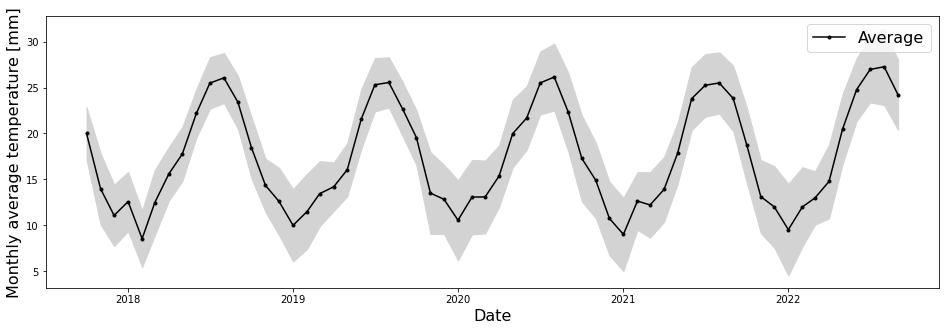

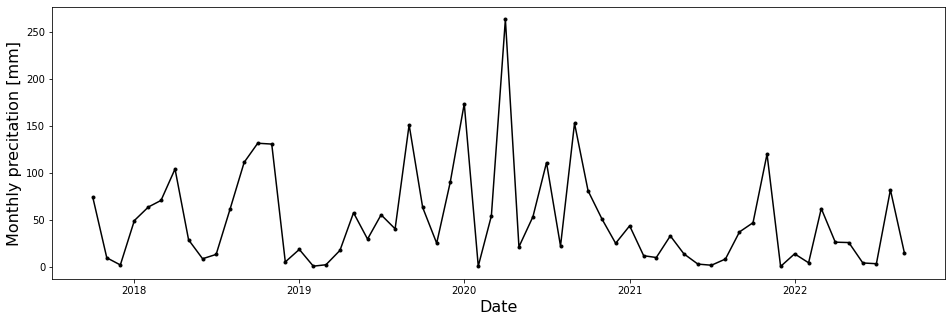

In [369]:
# LEAVE AS-IS

# Retrieve the last 5 years
weather_sample = weather_per_month.tail(5*12)

# Plot temperature
plot_min_avg_max(weather_sample, ylabel="Monthly average temperature [mm]")

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Monthly precitation [mm]")

<font size="+1">Here we can see that with less points we can see a smoother graphic which seems an harmonic funcition where it years increases and decreases at the same dates. In the precipitations now we can see a more continious graphic, these makes sense since we have computed the precipitations of all the month instead a week. In a whole month is more probable to rain at least one day avoiding the 0 values which were frequent on weekly and daily precipitations.</font>

# 2. Perform forecasting

## 2.1. Compute auto-correlation plots

In [370]:
def lagged_series(series, lag):
    original_trimmed = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        if j >= 0 and j <= len(series)-1:
            original_trimmed.append(series[i]) 
            lagged.append(series[j])
    return original_trimmed, lagged

In [371]:
# LEAVE AS-IS

assert ([44, 55, 66, 77, 88], [11, 22, 33, 44, 55]) == lagged_series([11,22,33,44,55,66,77,88], 3)

assert ([33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66]) == lagged_series([11,22,33,44,55,66,77,88], 2)

assert ([22, 33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66, 77]) == lagged_series([11,22,33,44,55,66,77,88], 1)


In [372]:
# LEAVE AS-IS

# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

In [373]:
def compute_autocorrelations(series, max_periods):
    correlations = []
    for i in range(max_periods):
        correlation = autocorrelation(series, i)
        correlations.append(correlation)
    return correlations

auto_correlations_temp = compute_autocorrelations(weather['temp_avg'], 2*365)
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'], 2*365)

In [374]:
# LEAVE AS-IS

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

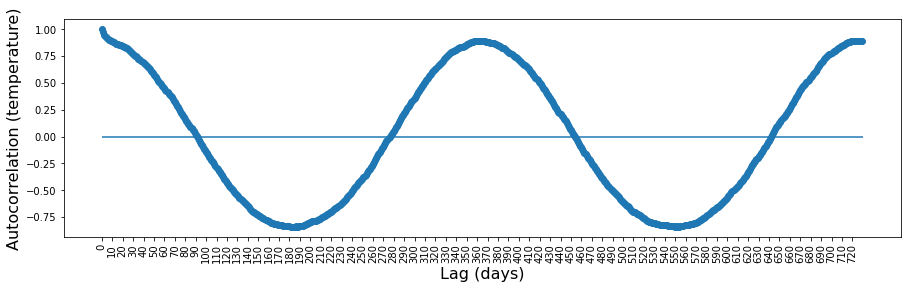

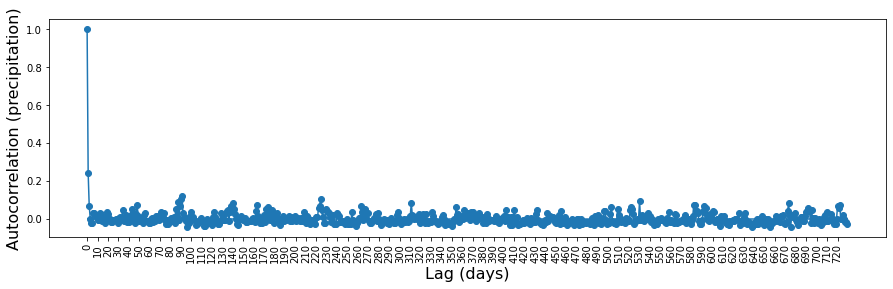

In [375]:
# LEAVE AS-IS

# Plot temperature auto-correlation
plot_auto_correlations(auto_correlations_temp, ylabel="Autocorrelation (temperature)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

<font size="+1">While in temperature we can clearly see a sinusoidal function with correlation of 1 when we are at a distance of 1 period and -1 at half period, in the precipitations plot we can't see any correlation, near to 0.</font>

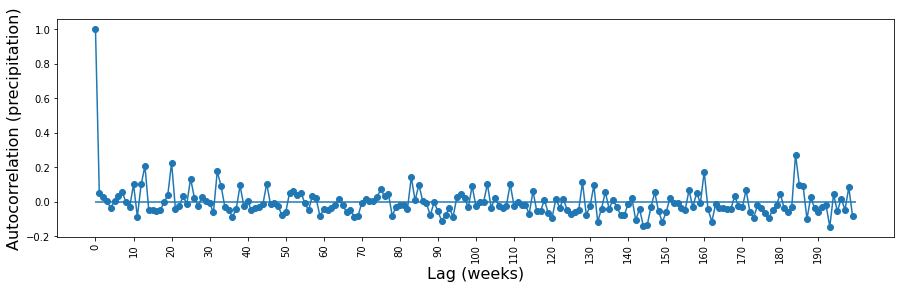

In [376]:
# LEAVE AS-IS

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

<font size="+1" >Now we can see a higher correlation, but without explaining anything concrete, it also seems random without following any pattern, of course that if we group the data in months or even years we will have higher correlation but this is due of the smoothing by computing the mean.</font>

## 2.2. Prepare a system of equations to learn an auto-regressive model

In [377]:
def prepare_matrices(series, lags):
    y = []
    X = []

    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))

    for i in range(np.max(lags), len(series)):
        row = []
        if not np.isnan(series[i]):
            isNaN = False
            for lag in lags:
                if np.isnan(series[i-lag]):
                    isNaN = True
                    break
                else:
                    row.append(series[i-lag])

            if not isNaN:
                X.append(row)
                y.append(series[i])
        
    return X, y

In [378]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 19, 32, np.nan, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32, 19], [58, 51]]
y=[51, 81]


In [379]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 19, 32, 38, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]


## 2.3. Perform forecasts

In [380]:
# LEAVE AS-IS

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='green', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

In [381]:
lags_monthly_temperature = [1,12,13,24]

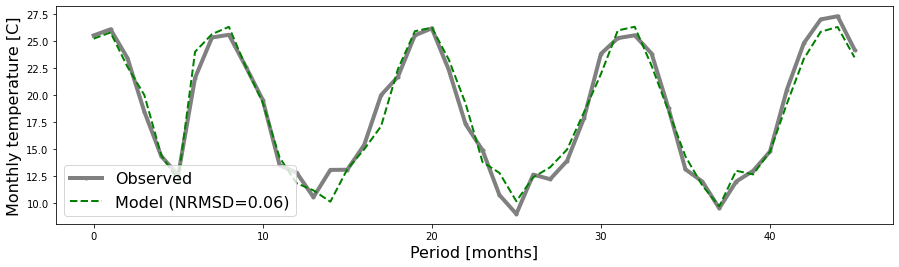

In [382]:
# LEAVE AS-IS
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly temperature [C]", nrmsd=nrmsd)

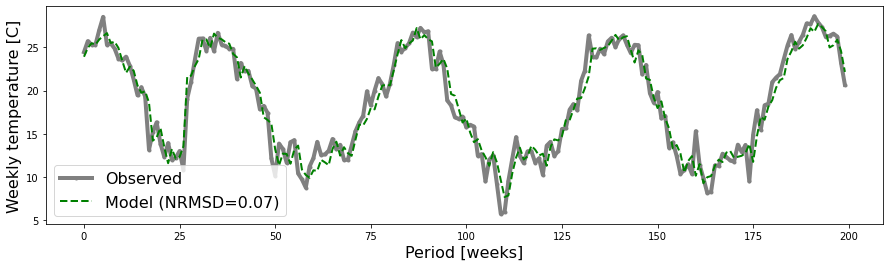

In [383]:
lags_weekly_temperature = [1,52,53,104]
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['temp_avg'], lags_weekly_temperature)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly temperature [C]", nrmsd=nrmsd)

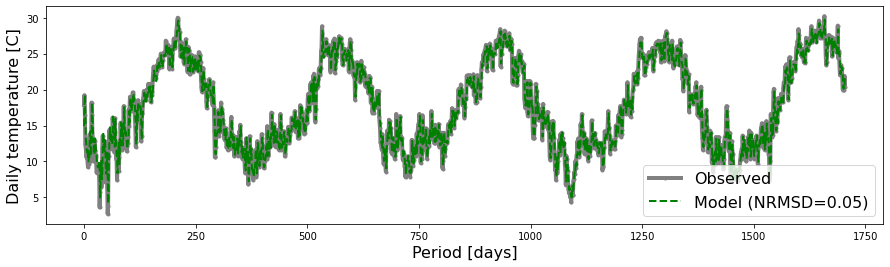

In [384]:
lags_daily_temperature = [1,2,364,365]
(y, y_pred, nrmsd) = perform_forecast(weather['temp_avg'].dropna(), lags_daily_temperature)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd)

<font size="+1">As we can see the most accurate method is the daily one because temperature tends to be very similar from one day to another while is harder to predict if one week will appear some climate phenomenon such as heat waves. Also the monthly one is also accurate since we are working with a bigger sample of days making possible to smooth the possible outliers.</font>

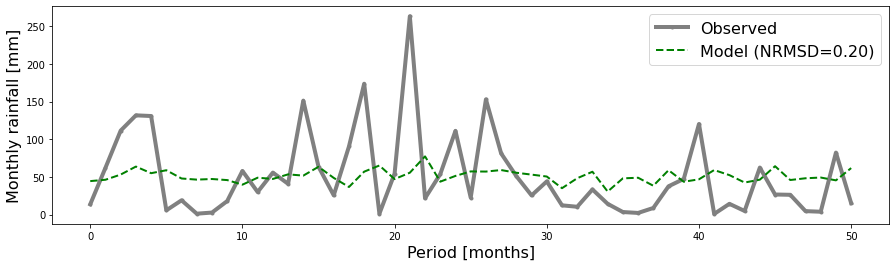

In [385]:
lags_monthly_rainfall = [1,12,13,24]
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['rainfall'], lags_monthly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly rainfall [mm]", nrmsd=nrmsd)

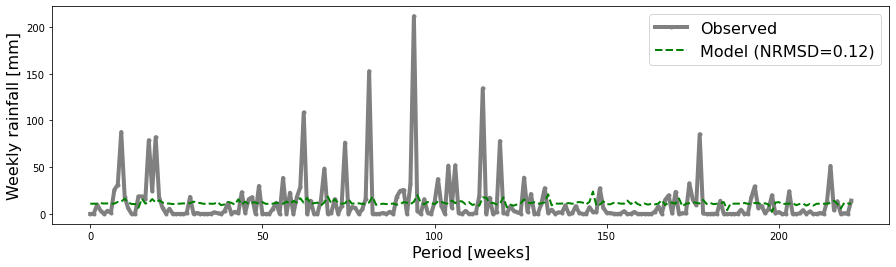

In [386]:
lags_weekly_rainfall = [1,52,53,104]
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['rainfall'], lags_weekly_temperature)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly rainfall [mm]", nrmsd=nrmsd)

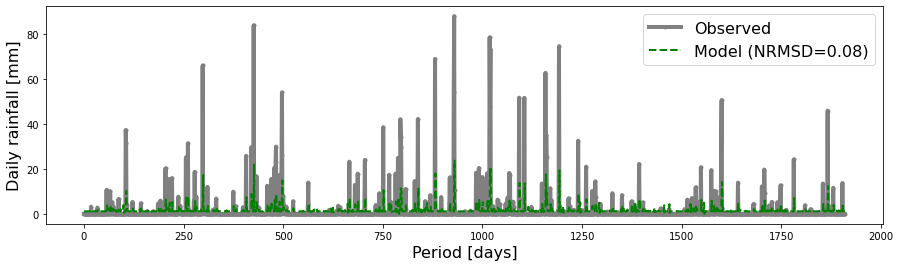

In [387]:
lags_daily_rainfall = [1,2,364,365]
(y, y_pred, nrmsd) = perform_forecast(weather['rainfall'].dropna(), lags_daily_rainfall)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily rainfall [mm]", nrmsd=nrmsd)

<font size="+1">While there is an obvious correlation between the temperature and the days it is different in precipitations, the predictions have a low NRMSD due to the avg value is closer to 0 and there are more days without rain so predicting that it would rain a little reduces the squre error but is not reliable. Despite this, the most accurate is the daily one.</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>